# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 3. Computer Vision: CNN for digits recognition

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

**Create the DataLoaders**

In [2]:
# Mean and standard deviation of all the pixels in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

# First, image transformed to tensor, then normalized.
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,), (stddev_gray,))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [3]:
# This math gets us back to original pixel values
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

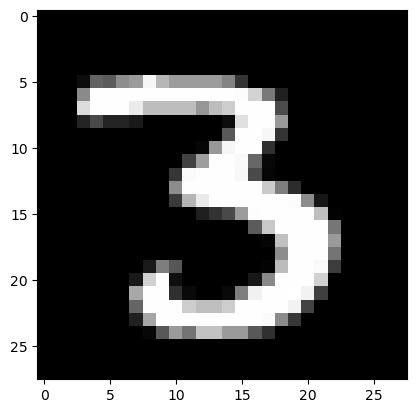

In [4]:
plt.imshow(img.reshape(28, 28), cmap='gray')
# Note that each image is 28 x 28 pixel

In [5]:
label = mnist_train[12][1]
label

3

In [6]:
batch_size = 1024 # Reduce this if you get out-of-memory error

In [7]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

**Create the model**

**Dropout**:

* A regularization technique: i.e. a technique to prevent overfitting, where the model becomes really good on the training dataset, but poor on the validation/testing dataset (unseen data)
* Randomly selected neurons are "switched off" or prevented from firing during each pass
* Thus, at every iteration, the model works with n% of it's neurons missing, where n is specified in the dropout layer (typically 0.5 or 50%)
* The result of this is that when random neurons are dropped, the alive neurons have to step in to generate the correct representation to decrease the loss function
* Thus the network becomes less sensitive to the weights of a selective few neurons, and become better at generalizing the features without overfitting the training data

Paper: [http://jmlr.org/papers/v15/srivastava14a.html](http://jmlr.org/papers/v15/srivastava14a.html)

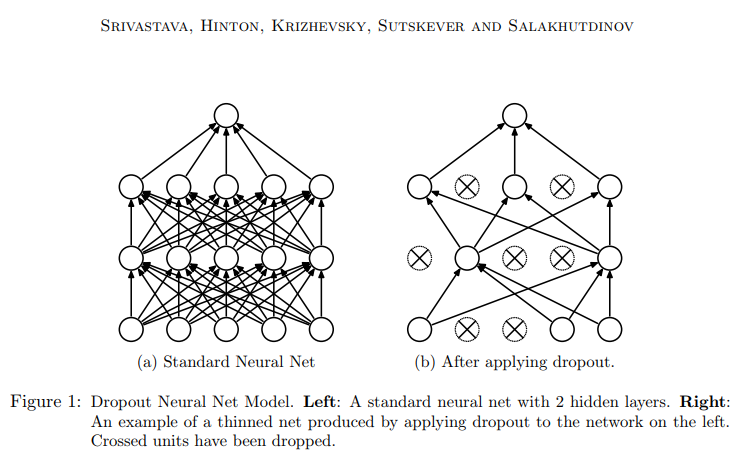

In [8]:
class MNISTNet(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        # (20 means 20 output channels)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)     # 20 x 20 x 30  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)             # Same as above
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 30  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        # (10 x 10 x 30 = 3000 inputs)
        self.fc1 = nn.Linear(3000, 500)
        # (10 output class, one for each digit 0 - 9)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        # (Grid to vector)
        x = x.view(-1, 3000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

**Create the objects**

In [9]:
# The model
net = MNISTNet()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
# Stochastic Gradient Descent
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

**Training loop**

(Takes about half an hour on my laptop, with Cuda)

In [10]:
from datetime import datetime

num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

print("Cuda available:", cuda.is_available())    
start_dt = datetime.utcnow()

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        # (Same steps as Part Two)
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item()  # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        # (See Part Two notebook for info about this)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    # Note: dropout doesn't happen in eval() mode
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        # (See Part Two notebook for info about this)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))
    end_dt = datetime.utcnow()
    total_s = (end_dt - start_dt).seconds
    minutes = int(total_s/60)
    seconds = total_s - minutes * 60 
    print(f"Time elapsed (minutes): {minutes}:{seconds}")

Cuda available: True
Epoch 1/100, Tr Loss: 1.1433, Tr Acc: 63.0833, Val Loss: 0.3480, Val Acc: 89.6700
Time elapsed (minutes): 0:11
Epoch 2/100, Tr Loss: 0.3334, Tr Acc: 90.1883, Val Loss: 0.2086, Val Acc: 93.9700
Time elapsed (minutes): 0:22
Epoch 3/100, Tr Loss: 0.2356, Tr Acc: 93.1650, Val Loss: 0.1545, Val Acc: 95.1300
Time elapsed (minutes): 0:33
Epoch 4/100, Tr Loss: 0.1928, Tr Acc: 94.5133, Val Loss: 0.1248, Val Acc: 96.1000
Time elapsed (minutes): 0:44
Epoch 5/100, Tr Loss: 0.1615, Tr Acc: 95.3200, Val Loss: 0.1102, Val Acc: 96.7400
Time elapsed (minutes): 0:54
Epoch 6/100, Tr Loss: 0.1412, Tr Acc: 95.8117, Val Loss: 0.0959, Val Acc: 97.0900
Time elapsed (minutes): 1:5
Epoch 7/100, Tr Loss: 0.1267, Tr Acc: 96.3100, Val Loss: 0.0829, Val Acc: 97.4900
Time elapsed (minutes): 1:16
Epoch 8/100, Tr Loss: 0.1140, Tr Acc: 96.5917, Val Loss: 0.0758, Val Acc: 97.7300
Time elapsed (minutes): 1:27
Epoch 9/100, Tr Loss: 0.1058, Tr Acc: 96.8950, Val Loss: 0.0743, Val Acc: 97.6800
Time elaps

Epoch 74/100, Tr Loss: 0.0199, Tr Acc: 99.3567, Val Loss: 0.0302, Val Acc: 99.0400
Time elapsed (minutes): 13:19
Epoch 75/100, Tr Loss: 0.0209, Tr Acc: 99.3117, Val Loss: 0.0334, Val Acc: 98.9300
Time elapsed (minutes): 13:30
Epoch 76/100, Tr Loss: 0.0211, Tr Acc: 99.3350, Val Loss: 0.0312, Val Acc: 99.0700
Time elapsed (minutes): 13:40
Epoch 77/100, Tr Loss: 0.0193, Tr Acc: 99.3733, Val Loss: 0.0308, Val Acc: 99.0200
Time elapsed (minutes): 13:51
Epoch 78/100, Tr Loss: 0.0187, Tr Acc: 99.3783, Val Loss: 0.0326, Val Acc: 99.0500
Time elapsed (minutes): 14:2
Epoch 79/100, Tr Loss: 0.0209, Tr Acc: 99.3217, Val Loss: 0.0328, Val Acc: 99.0300
Time elapsed (minutes): 14:13
Epoch 80/100, Tr Loss: 0.0202, Tr Acc: 99.3500, Val Loss: 0.0317, Val Acc: 99.1600
Time elapsed (minutes): 14:23
Epoch 81/100, Tr Loss: 0.0190, Tr Acc: 99.3867, Val Loss: 0.0333, Val Acc: 99.0300
Time elapsed (minutes): 14:34
Epoch 82/100, Tr Loss: 0.0203, Tr Acc: 99.3300, Val Loss: 0.0323, Val Acc: 99.0400
Time elapsed (

In [11]:
torch.save(net.state_dict(), "./3.model.pth")

**Visialize the loss and accuracy**

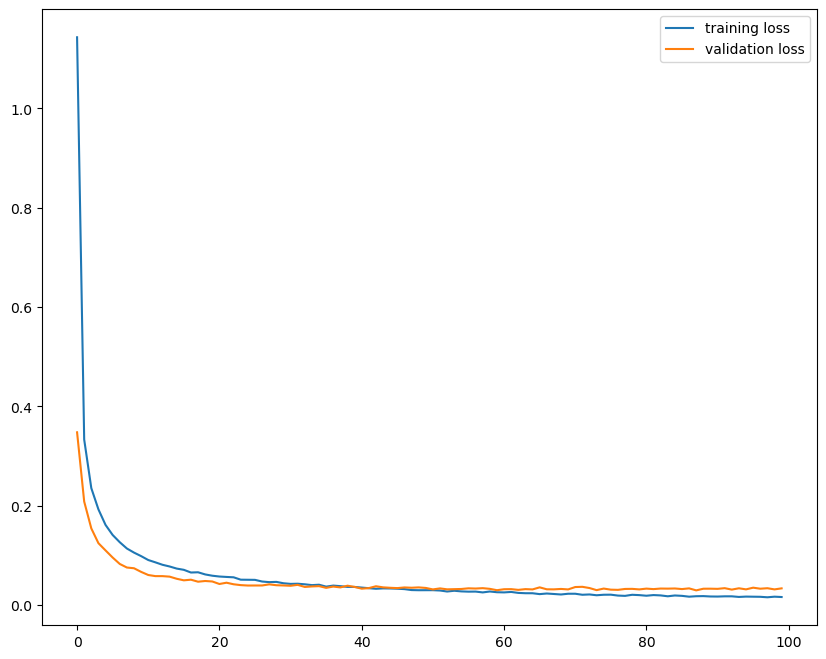

In [12]:
# Loss

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

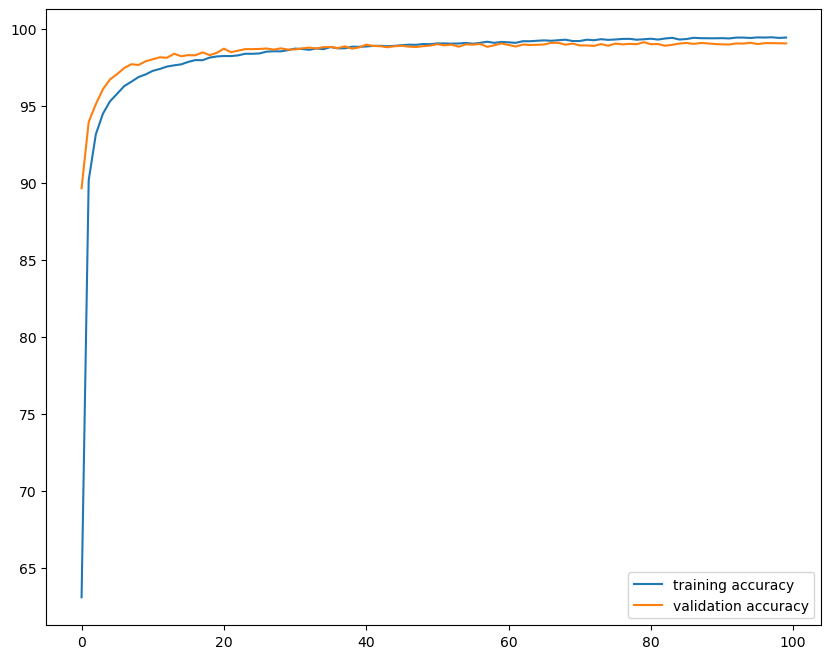

In [13]:
# Accuracy

f = plt.figure(figsize=(10, 8))
train_accuracy_cpu = [ta.cpu() for ta in train_accuracy]
plt.plot(train_accuracy_cpu, label='training accuracy')
valid_accuracy_cpu = [va.cpu() for va in valid_accuracy]
plt.plot(valid_accuracy_cpu, label='validation accuracy')
plt.legend()
plt.show()

**Standalone inference**

In [14]:
image_index = 23
# 28 x 28 image, 1 channel, 1 element
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]

net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

In [15]:
# Look for highest score on element 5
output.data

tensor([[ -1.2211,  -4.8490, -10.1300,   8.5584, -13.9525,  38.9199,   3.0591,
         -17.5736,  -0.8375,  14.7653]], device='cuda:0')

In [16]:
_, predicted = torch.max(output.data, 1)
print("Prediction is: ", predicted)

Prediction is:  tensor([5], device='cuda:0')


In [17]:
print("Actual is is: ", label)

Actual is is:  5


## Homework

* Play with the various moving parts in this notebook and try to increase the accuracy
* Try a different dataset (http://pytorch.org/docs/master/torchvision/datasets.html)
* Try data augmentation (http://pytorch.org/docs/master/torchvision/transforms.html)
* Read about contest winning CNN architectures (https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)

Notes:
* Augmentation means adding random noise to image, rotating it, etc.